In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Data Download Function
def download_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10


/Users/anikarosenzuaig/automated_trading/env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - loss: 12903.0918 
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 12554.9785
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 11825.3174
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 10675.5635
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 10232.0400
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 9370.2910
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 8825.2334
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 8415.0518
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 8114.8535
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 8044.2817
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model Performance Metrics:

Model: GBR
MAE: 11.8843
MSE: 304.4893
RMSE: 17.4496
R²: -0.3890

Model: RF
MAE: 11.2663
MSE: 286.7658
RMSE: 16.9342
R²: -0.3081

Model: SVR
MAE: 23.0727
MSE: 924.5068
RMSE: 30.4057
R²: -3.2172

Model: LSTM
MAE: 156.2865
MSE: 24644.5998


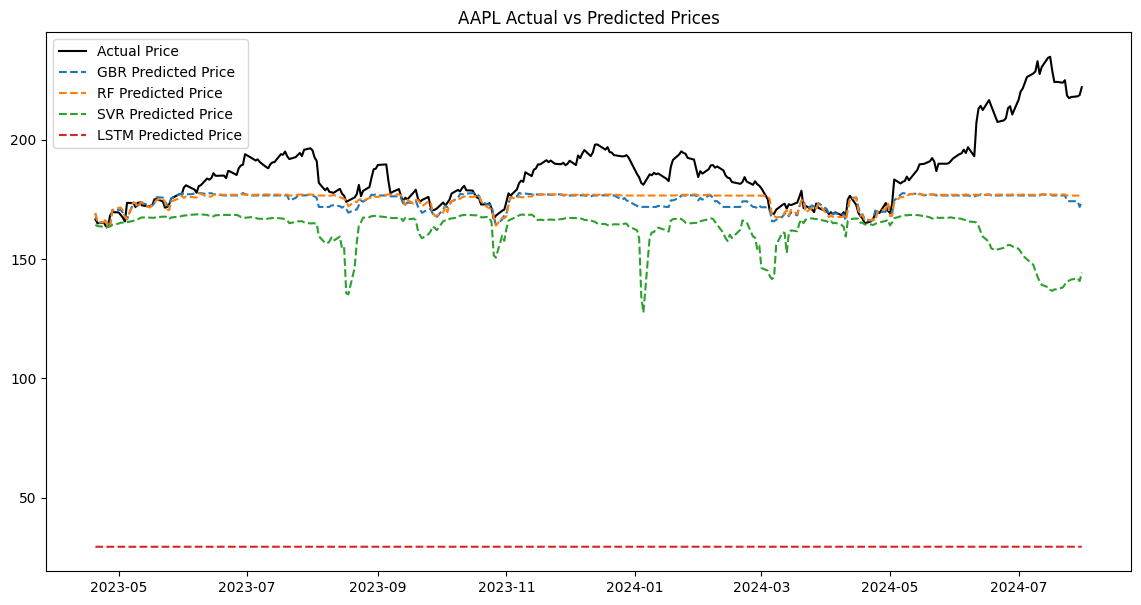

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import LSTM, Dense
import yfinance as yf

# Function to prepare features for time series forecasting
def prepare_features(data, n_lags=5):
    features = []
    target = data['Close']
    for i in range(n_lags, 0, -1):
        features.append(target.shift(i))
    features = pd.concat(features, axis=1)
    features.columns = [f'lag_{i}' for i in range(1, n_lags + 1)]
    features['SMA_20'] = data['Close'].rolling(window=20).mean()
    features['SMA_50'] = data['Close'].rolling(window=50).mean()
    features['RSI'] = 100 - (100 / (1 + data['Close'].pct_change().rolling(window=14).mean() / data['Close'].pct_change().rolling(window=14).std()))
    features.dropna(inplace=True)
    return features, target[features.index]

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, rmse, r2

# Load historical stock data
ticker = 'AAPL'
data = yf.download(ticker, start='2018-01-01', end='2024-08-01')

# Prepare features and target
n_lags = 5
X, y = prepare_features(data, n_lags)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling features for LSTM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, shuffle=False)

# Train and evaluate models
results = {}

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor()
mae, mse, rmse, r2 = evaluate_model(gbr, X_train, X_test, y_train, y_test)
results['GBR'] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}

# Random Forest Regressor
rf = RandomForestRegressor()
mae, mse, rmse, r2 = evaluate_model(rf, X_train, X_test, y_train, y_test)
results['RF'] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}

# Support Vector Regression
svr = SVR()
mae, mse, rmse, r2 = evaluate_model(svr, X_train, X_test, y_train, y_test)
results['SVR'] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}

# LSTM Model
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model = Sequential()
model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)

lstm_preds = model.predict(X_test_lstm).flatten()
mae = mean_absolute_error(y_test, lstm_preds)
mse = mean_squared_error(y_test, lstm_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, lstm_preds)
results['LSTM'] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}

# Print results
print("Model Performance Metrics:")
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Price', color='black')
for model_name, preds in zip(
    ['GBR', 'RF', 'SVR', 'LSTM'],
    [gbr.predict(X_test), rf.predict(X_test), svr.predict(X_test), lstm_preds]
):
    plt.plot(data.index[-len(y_test):], preds, label=f'{model_name} Predicted Price', linestyle='dashed')
plt.title(f'{ticker} Actual vs Predicted Prices')
plt.legend()
plt.show()
